In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import optimizers
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, Embedding
from keras.layers.core import Dense, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, f1_score, log_loss,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

pd.set_option('display.max_colwidth', 300)
np.random.seed(24)

2022-11-25 13:09:13.880254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 13:09:14.705145: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 13:09:16.585656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-25 13:09:16.585862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
df = pd.read_pickle('joint_dataset.pkl')

In [91]:
df[df.name == 'Titanic']

,title_id,genres,name,description,clean_plot,image_path
2407,tt0120338,"[romance, drama]",Titanic,"A seventeen-year-old aristocrat falls in love with a kind but poor artist aboard the luxurious, ill-fated R.M.S. Titanic.",seventeen year old aristocrat fall love kind poor artist aboard luxurious ill fat r titanic,./dataset/romance/tt0120338/poster.jpg


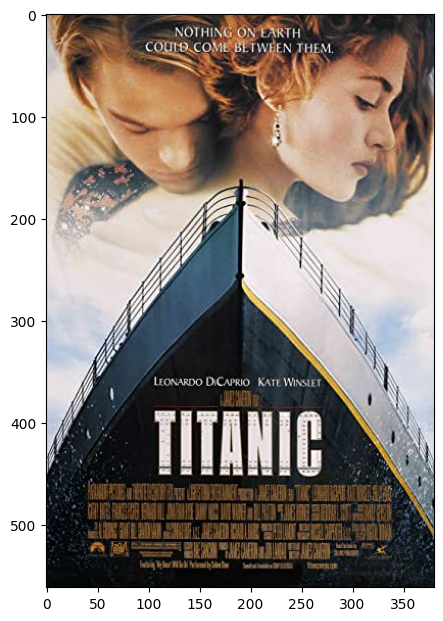

In [92]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread(df.image_path[2407])
plt.figure(figsize = (5,10))
plt.imshow(img)

In [15]:
# Making Vocabulary 

vocab = set()
all_words = ' '.join([text for text in df['clean_plot']]) 
all_words = all_words.split() 
for word in all_words:
    vocab.add(word)

voc_len = len(vocab)
voc_len


15090

In [16]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])

# transform target variable
# One-hot transformation
y = multilabel_binarizer.transform(df['genres'])
multilabel_binarizer.classes_

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'film noir',
       'history', 'horror', 'music', 'musical', 'mystery', 'romance',
       'sci-fi', 'short film', 'sport', 'superhero', 'thriller', 'war',
       'western'], dtype=object)

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8) # max_df filters the words that have frequency over 0.8

# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(df['clean_plot'], y, test_size=0.1, random_state=9)

# create TF-IDF features 
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain) 
xval_tfidf = tfidf_vectorizer.transform(xval)

In [18]:
from sklearn.linear_model import LogisticRegression 
# Binary Relevance 
from sklearn.multiclass import OneVsRestClassifier 
# Performance metric 
from sklearn.metrics import f1_score

# Logistic Regression

In [48]:
lr = LogisticRegression() 
clf = OneVsRestClassifier(lr)

# fit model on train data 
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [49]:
# make predictions for validation set 
y_pred = clf.predict(xval_tfidf)
# evaluate performance 
f1_score(yval, y_pred, average="micro")

0.09650582362728785

We can change the threshold value to have a better result (the default is 0.5)

In [50]:
# predict probabilities 
y_pred_prob = clf.predict_proba(xval_tfidf)

t = 0.122 # threshold value 
y_pred_new = (y_pred_prob >= t).astype(int)

# evaluate performance 
f1_score(yval, y_pred_new, average="micro")

0.4521465143757385

In [55]:
titles_1 = ['The Keeping Room', 'Hounddog', 'Wilde', 'Defiance', 'Home Alone 3']
titles_2 = ['The Great Mouse Detective', 'Luca', 'Kabluey', 'Son of the Mask', 'We Are Your Friends']

'leave without men dying day american civil war three woman must fight defend home two rogue soldier break fast approaching union army'

In [70]:
def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    y_pred_prob = clf.predict_proba(q_vec)
    q_pred = (y_pred_prob >= t).astype(int)
    #q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

for title in titles_2: 
    print("Movie: ", title, "\nPredicted genre: ", infer_tags(df[df.name==title].clean_plot.values[0]))
    print("Actual genre: ", df[df.name==title]['genres'].values[0], "\n")

Movie:  The Great Mouse Detective 
Predicted genre:  [('animation', 'mystery')]
Actual genre:  ['musical', 'animation'] 

Movie:  Luca 
Predicted genre:  [('adventure', 'animation', 'comedy', 'family', 'fantasy', 'sci-fi')]
Actual genre:  ['comedy', 'animation', 'fantasy', 'family', 'adventure'] 

Movie:  Kabluey 
Predicted genre:  [()]
Actual genre:  ['superhero'] 

Movie:  Son of the Mask 
Predicted genre:  [('family', 'superhero')]
Actual genre:  ['superhero', 'family'] 

Movie:  We Are Your Friends 
Predicted genre:  [('music',)]
Actual genre:  ['music'] 



In [98]:
def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    y_pred_prob = clf.predict_proba(q_vec)
    q_pred = (y_pred_prob >= t).astype(int)
    #q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ", df['genres'][k], "\n")

Movie:  9 Kisses 
Predicted genre:  [('documentary', 'short film')]
Actual genre:  ['short film'] 

Movie:  Thank God 
Predicted genre:  [('sport',)]
Actual genre:  ['comedy', 'fantasy'] 

Movie:  AM1200 
Predicted genre:  [()]
Actual genre:  ['short film'] 

Movie:  The Heat 
Predicted genre:  [('crime',)]
Actual genre:  ['crime'] 

Movie:  The Stanford Prison Experiment 
Predicted genre:  [()]
Actual genre:  ['biography', 'history'] 



In [99]:
# Calculating the metrics
precision = precision_score(yval, y_pred_new, average="micro")
recall = recall_score(yval, y_pred_new, average="micro")
accuracy = accuracy_score(yval, y_pred_new)
f1 = f1_score(yval, y_pred_new, average="micro")
logloss = log_loss(yval, y_pred_prob)

In [100]:
# Calculation output
print("Precision = ", precision)
print("Recall  = ", recall)
print('Accuracy = ', accuracy)
print("F1 score = ", f1)
print("Log-loss = ", logloss)

Precision =  0.4108804581245526
Recall  =  0.5026269702276708
Accuracy =  0.15104895104895105
F1 score =  0.4521465143757385
Log-loss =  4.041057832935816


In [101]:
results = pd.DataFrame(columns=['Probability_threshold', 'Precision', 'Recall', 'Accuracy', 'F1 score', 'Log-loss'])
results.loc['Logistic Regression'] = [t, precision, recall, accuracy, f1, logloss]

# Support Vector Machine

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [20]:
svm = SVC()
clf_2 = OneVsRestClassifier(svm)

# fit model on train data 
clf_2.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=SVC())

In [21]:
# make predictions for validation set 
y_pred = clf_2.predict(xval_tfidf)
# evaluate performance 
f1_score(yval, y_pred, average="micro")

0.12274959083469719

In [22]:
# Evaluating the model
print(f"Test Set Accuracy : {accuracy_score(yval, y_pred) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(yval, y_pred, zero_division=0)}")

Test Set Accuracy : 7.1328671328671325 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        61
           3       0.00      0.00      0.00        53
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00        51
           6       0.75      0.12      0.21        50
           7       0.00      0.00      0.00        37
           8       0.00      0.00      0.00        53
           9       0.00      0.00      0.00        49
          10       1.00      0.06      0.12        49
          11       0.00      0.00      0.00        42
          12       1.00      0.05      0.09        43
          13       0.88      0.12      0.22        57
          14       1.00      0.07      0.12        45
          15       0.00      0.00      0.00        49
          16

In [47]:
def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf_2.predict(q_vec).astype(int)
    #q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ", df['genres'][k], "\n")

Movie:  October Sky 
Predicted genre:  [()]
Actual genre:  ['biography', 'family'] 

Movie:  IMDbrief 
Predicted genre:  [()]
Actual genre:  ['short film'] 

Movie:  Dead End 
Predicted genre:  [()]
Actual genre:  ['film noir'] 

Movie:  The Princess 
Predicted genre:  [()]
Actual genre:  ['documentary'] 

Movie:  A Fish Called Wanda 
Predicted genre:  [()]
Actual genre:  ['crime'] 



In [25]:
# Calculation output
t = 0.5
print("Precision = ", precision_score(yval, y_pred, average="micro"))
print("Recall  = ", recall_score(yval, y_pred, average="micro"))
print("Accuracy = ", accuracy_score(yval, y_pred))
print("F1 score = ", f1_score(yval, y_pred, average="micro"))

results.loc["Support Vector Machine"] = [
    t,
    precision_score(yval, y_pred, average="micro"),
    recall_score(yval, y_pred, average="micro"),
    accuracy_score(yval, y_pred),
    f1_score(yval, y_pred, average="micro"),
    '_'
]


Precision =  0.9375
Recall  =  0.06567425569176882
Accuracy =  0.07132867132867132
F1 score =  0.12274959083469719


NameError: name 'results' is not defined

# Decision Tree

In [107]:
from sklearn import tree

In [108]:
dec_tree = tree.DecisionTreeClassifier(random_state = 42)
clf_3 = OneVsRestClassifier(dec_tree)

# fit model on train data 
clf_3.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=DecisionTreeClassifier(random_state=42))

In [109]:
# make predictions for validation set 
y_pred = clf_3.predict(xval_tfidf)
# evaluate performance 
f1_score(yval, y_pred, average="micro")

0.29616724738675965

In [123]:
# predict probabilities 
y_pred_prob = clf_3.predict_proba(xval_tfidf)

t = 0.75 # threshold value 
y_pred_new = (y_pred_prob >= t).astype(int)

# evaluate performance 
f1_score(yval, y_pred_new, average="micro")

0.29616724738675965

In [124]:
def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    y_pred_prob = clf_3.predict_proba(q_vec)
    q_pred = (y_pred_prob >= t).astype(int)
    #q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ", df['genres'][k], "\n")

Movie:  Ocean's Eleven 
Predicted genre:  [('crime', 'musical', 'war')]
Actual genre:  ['music'] 

Movie:  Zeros and Ones 
Predicted genre:  [('war',)]
Actual genre:  ['war'] 

Movie:  The Rugrats Movie 
Predicted genre:  [('documentary',)]
Actual genre:  ['musical', 'animation'] 

Movie:  Trois couleurs: Bleu 
Predicted genre:  [()]
Actual genre:  ['music'] 

Movie:  Chernobyl 
Predicted genre:  [('superhero',)]
Actual genre:  ['history'] 



In [125]:
# Calculating the metrics
precision_1 = precision_score(yval, y_pred_new, average="micro")
recall_1 = recall_score(yval, y_pred_new, average="micro")
accuracy_1 = accuracy_score(yval, y_pred_new)
f1_score_1 = f1_score(yval, y_pred_new, average="micro")
logloss_1 = log_loss(yval, y_pred_prob)

In [126]:
# Calculation output
print("Precision = ", precision_1)
print("Recall  = ", recall_1)
print('Accuracy = ', accuracy_1)
print("F1 score = ", f1_score_1)
print("Log-loss = ", logloss_1)

results.loc["Decision Tree"] = [
    t,
    precision_1,
    recall_1,
    accuracy_1,
    f1_score_1,
    logloss_1,
]

Precision =  0.29462738301559793
Recall  =  0.29772329246935203
Accuracy =  0.1020979020979021
F1 score =  0.29616724738675965
Log-loss =  30.112624443604705


# Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier

In [128]:
forest = RandomForestClassifier(random_state = 42)
clf_4 = OneVsRestClassifier(forest)

# fit model on train data 
clf_4.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))

In [129]:
# make predictions for validation set 
y_pred = clf_4.predict(xval_tfidf)
# evaluate performance 
f1_score(yval, y_pred, average="micro")

0.18535825545171336

In [133]:
# predict probabilities 
y_pred_prob = clf_4.predict_proba(xval_tfidf)

t = 0.23 # threshold value 
y_pred_new = (y_pred_prob >= t).astype(int)

# evaluate performance 
f1_score(yval, y_pred_new, average="micro")

0.3939688715953307

In [134]:
def infer_tags(q):
    q_vec = tfidf_vectorizer.transform([q])
    y_pred_prob = clf_4.predict_proba(q_vec)
    q_pred = (y_pred_prob >= t).astype(int)
    #q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ", df['genres'][k], "\n")

Movie:  Cici 
Predicted genre:  [()]
Actual genre:  ['drama'] 

Movie:  Three Thousand Years of Longing 
Predicted genre:  [()]
Actual genre:  ['romance', 'drama', 'fantasy'] 

Movie:  The Scorpion King 
Predicted genre:  [('action', 'adventure')]
Actual genre:  ['fantasy'] 

Movie:  Eragon 
Predicted genre:  [('war',)]
Actual genre:  ['family'] 

Movie:  La casa lobo 
Predicted genre:  [('war',)]
Actual genre:  ['animation'] 



In [135]:
# Calculating the metrics
precision_2 = precision_score(yval, y_pred_new, average="micro")
recall_2 = recall_score(yval, y_pred_new, average="micro")
accuracy_2 = accuracy_score(yval, y_pred_new)
f1_score_2 = f1_score(yval, y_pred_new, average="micro")
logloss_2 = log_loss(yval, y_pred_prob)

In [136]:
# Calculation output
print("Precision = ", precision_2)
print("Recall  = ", recall_2)
print('Accuracy = ', accuracy_2)
print("F1 score = ", f1_score_2)
print("Log-loss = ", logloss_2)

results.loc["Random Forest"] = [
    t,
    precision_2,
    recall_2,
    accuracy_2,
    f1_score_2,
    logloss_2,
]

Precision =  0.4431072210065646
Recall  =  0.35464098073555167
Accuracy =  0.18461538461538463
F1 score =  0.3939688715953307
Log-loss =  6.035745096221851


# Предварительный итог

In [137]:
# Единая табличка с результатами
results

,Probability_threshold,Precision,Recall,Accuracy,F1 score,Log-loss
Logistic Regression,0.122,0.410880,0.502627,0.151049,0.452147,4.041058
Support Vector Machine,0.122,0.937500,0.065674,0.071329,0.122750,_
Decision Tree,0.750,0.294627,0.297723,0.102098,0.296167,30.112624
Random Forest,0.230,0.443107,0.354641,0.184615,0.393969,6.035745


To do: посмотреть, какие метрики корректнее использовать в данной задаче

# LSTM

In [3]:
x_list = df['clean_plot'].values.tolist()
#y_list = df.genre.values
y_list = df.genres.values

x = np.array(x_list)
y = np.array(y_list)

In [4]:
tk = Tokenizer(split=" ")
tk.fit_on_texts(x)

In [5]:
x_train = tk.texts_to_sequences(x)

word_index = tk.word_index # index of unique words
print('Found %s unique tokens.' % len(word_index))

Found 15090 unique tokens.


In [6]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y)

lengths = [len(text.split()) for text in x_list]
max_len = max(lengths)
batch_size = 100
epochs = 500
max_features = len(word_index) + 1

In [7]:
x_train = pad_sequences(x_train, maxlen=max_len, padding='pre')
indices = np.arange(len(x_train))

x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x_train, y_train, indices, test_size=0.2, random_state=42)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (5716, 178)
x_test shape: (1430, 178)
y_train shape: (5716, 24)
y_test shape: (1430, 24)


In [8]:
labels_num = len(y_train[0])

embeddings_index = {}
f = open('./glove.6B/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [9]:
embedding_matrix = np.zeros((max_features, 100))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(
    input_dim=max_features, output_dim=100, weights=[embedding_matrix], 
    mask_zero=True,
    input_length=max_len,
    trainable=False
)


In [10]:
model = Sequential()
model.add(embedding_layer)
# Dropouts can help correct overfitting by dropping out a fraction of inputs - it can reduce specificity of weights
# Ставится перед тем слоем, к инпутам в который применяется. Здесь дропаут - 30%
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
# model.add(Dense(labels_num, activation='softmax'))
model.add(
    Dense(units=labels_num, activation="sigmoid")
)  # 'units' - число юнитов в слое нейронки, соответствует числу аутпутов


print(model.summary())


2022-11-25 13:09:48.833552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-25 13:09:49.003865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-25 13:09:49.003890: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-25 13:09:49.005418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 178, 100)          1509100   
                                                                 
 dropout (Dropout)           (None, 178, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 178, 128)          117248    
                                                                 
 dropout_1 (Dropout)         (None, 178, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 24)                1

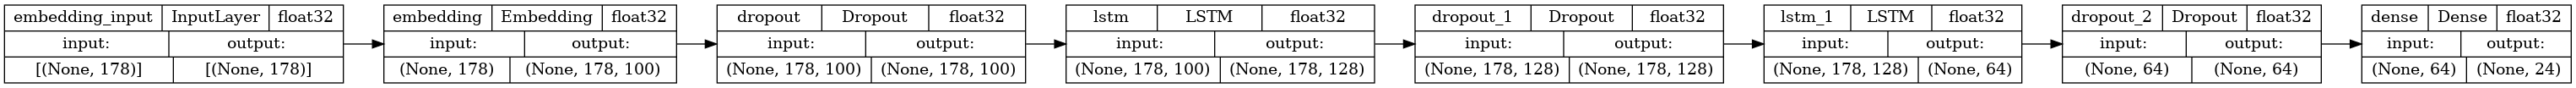

In [14]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, show_dtype=True, rankdir='LR') #, show_layer_activations=True

In [153]:
rmsprop = optimizers.RMSprop(learning_rate = 0.01, decay = 0.0001)
model.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics=['categorical_accuracy'])

In [154]:
es = EarlyStopping(patience=10)
csv_logger = CSVLogger('./Text Models/lstm_history_log_(0,3).csv', append=True)
check_point = ModelCheckpoint(filepath='./Text Models/best_lstm_model_(0,3)_todate', save_best_only=True, save_weights_only=True)

In [155]:
#@tensorflow.autograph.experimental.do_not_convert
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks = [es, csv_logger, check_point]
)


Epoch 1/500
46/46 [==============================] - 35s 624ms/step - loss: 0.2746 - categorical_accuracy: 0.0424 - val_loss: 0.2518 - val_categorical_accuracy: 0.0857
Epoch 2/500
46/46 [==============================] - 35s 765ms/step - loss: 0.2569 - categorical_accuracy: 0.0612 - val_loss: 0.2414 - val_categorical_accuracy: 0.1014
Epoch 3/500
46/46 [==============================] - 34s 733ms/step - loss: 0.2347 - categorical_accuracy: 0.1413 - val_loss: 0.2214 - val_categorical_accuracy: 0.1670
Epoch 4/500
46/46 [==============================] - 28s 619ms/step - loss: 0.2187 - categorical_accuracy: 0.1831 - val_loss: 0.2185 - val_categorical_accuracy: 0.1888
Epoch 5/500
46/46 [==============================] - 29s 624ms/step - loss: 0.2083 - categorical_accuracy: 0.2242 - val_loss: 0.2035 - val_categorical_accuracy: 0.2622
Epoch 6/500
46/46 [==============================] - 27s 586ms/step - loss: 0.2006 - categorical_accuracy: 0.2598 - val_loss: 0.1973 - val_categorical_accuracy:

In [156]:
model.save_weights('./Text Models/lstm_model_weights_(0,3).h5')
model.save('./Text Models/lstm_model_(0,3).h5')

In [26]:
from keras.models import load_model

model = load_model('./Text Models/lstm_model_(0,3).h5')
model.load_weights('./Text Models/lstm_model_weights_(0,3).h5', by_name=False, skip_mismatch=False, options=None)

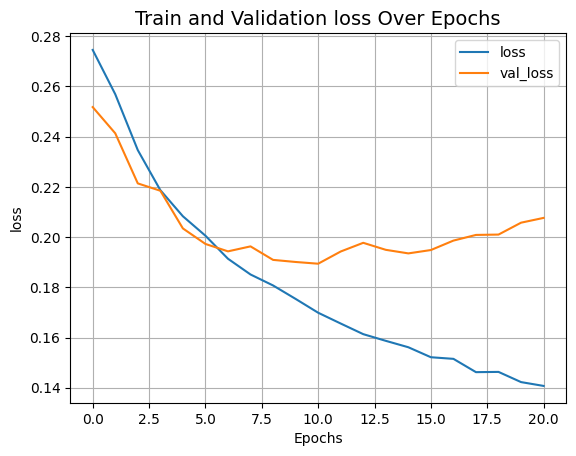

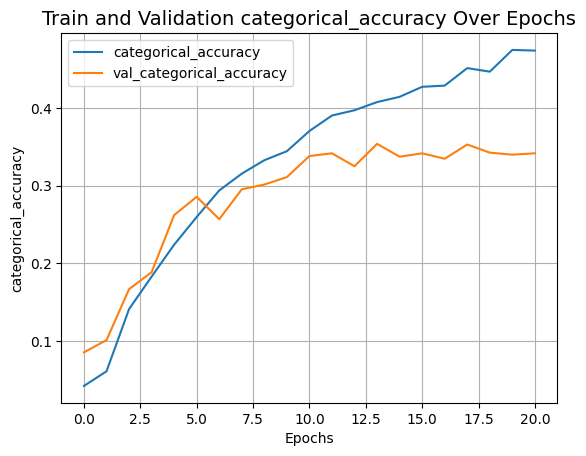

In [160]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

We can see here overfitting, so we should increase the capacity of the network by making it wider or deeper.

In [27]:
out = model.predict(x_test)
out = np.array(out)

y_pred = np.zeros(out.shape)

# for i in range(len(out[:, 0])):
#     a = out[i, :]
#     index = np.argpartition(a, -5)[-5:]
#     for j in range(len(index)):
#         y_pred[i, index[j]] = 1

y_pred[out > 0.5] = 1

f1_score(y_test, y_pred, average="micro")


45/45 [==============================] - 5s 79ms/step


0.3398360192253322

In [28]:
t = 0.27  # threshold value

y_pred_new = np.zeros(out.shape)
y_pred_new[out > t] = 1

# evaluate performance
f1_score(y_test, y_pred_new, average="micro")


0.40754257907542585

In [29]:
# Inference
def inference(q, k):
    q_vec = tk.texts_to_sequences(q)
    q_vec = pad_sequences(q_vec, maxlen=max_len, padding='pre')[k]
    q_pred_prob = model.predict(q_vec.reshape(1, max_len))
    q_pred = np.zeros(q_pred_prob.shape)
    q_pred[q_pred_prob > t] = 1

    return mlb.inverse_transform(q_pred)


for i in range(5):
    k = np.random.choice(indices_test)
    print(
        "Movie: ",
        df["name"][k],
        "\nPredicted genre: ",
        inference(x, k),
    ), print("Actual genre: ", df["genres"][k], "\n")


1/1 [==============================] - 0s 56ms/step
Movie:  The Great Mouse Detective 
Predicted genre:  [('adventure', 'animation', 'comedy', 'family', 'fantasy')]
Actual genre:  ['musical', 'animation'] 

1/1 [==============================] - 0s 47ms/step
Movie:  Luca 
Predicted genre:  [('adventure', 'animation', 'comedy', 'family', 'fantasy')]
Actual genre:  ['comedy', 'animation', 'fantasy', 'family', 'adventure'] 

1/1 [==============================] - 0s 46ms/step
Movie:  Kabluey 
Predicted genre:  [('short film',)]
Actual genre:  ['superhero'] 

1/1 [==============================] - 0s 48ms/step
Movie:  Son of the Mask 
Predicted genre:  [('animation', 'family')]
Actual genre:  ['superhero', 'family'] 

1/1 [==============================] - 0s 48ms/step
Movie:  We Are Your Friends 
Predicted genre:  [('music', 'musical')]
Actual genre:  ['music'] 



In [186]:
accuracy_lstm = accuracy_score(y_test, y_pred_new)
precision = precision_score(y_test, y_pred_new, average="samples", zero_division=0)
recall = recall_score(y_test, y_pred_new, average="samples")
f1 = f1_score(y_test, y_pred_new, average="samples")
log_loss_lstm = log_loss(y_test, out)


In [187]:
# Calculation output
print("Precision = ", precision)
print("Recall  = ", recall)
print('Accuracy = ', accuracy_lstm)
print("F1 score = ", f1)
print("Log-loss = ", log_loss_lstm)

results.loc["LSTM(0.3)"] = [
    t,
    precision,
    recall,
    accuracy_lstm,
    f1,
    log_loss_lstm,
]

Precision =  0.3975674325674325
Recall  =  0.4427600177600178
Accuracy =  0.18811188811188811
F1 score =  0.39249896568078385
Log-loss =  4.465527115400125


In [188]:
results

,Probability_threshold,Precision,Recall,Accuracy,F1 score,Log-loss
Logistic Regression,0.122,0.410880,0.502627,0.151049,0.452147,4.041058
Support Vector Machine,0.122,0.937500,0.065674,0.071329,0.122750,_
Decision Tree,0.750,0.294627,0.297723,0.102098,0.296167,30.112624
Random Forest,0.230,0.443107,0.354641,0.184615,0.393969,6.035745
LSTM(0.3),0.270,0.397567,0.442760,0.188112,0.392499,4.465527


Варианты улучшения:
- Увеличить долю Dropout (до 0.5, к примеру)
- Добавить ещё слоёв 
- Увеличить количество юнитов в слоях
- Подобрать другой оптимизатор
- Подобрать другую активацию
- Попробовать ансамбль моделей
- Посмотреть принципильно другие нейронки, классифицирующие тексты, извлекающие характеристики из текстов, помимо LSTM


Все эти стратегии итерационно перебрать, используя алгоритм Earlystopping. Сравнивать по метрикам и результатам (на одном и том же сэмпле, а не рандомном).

### Dropout 0.5:

In [189]:
csv_logger_2 = CSVLogger('./Text Models/lstm_history_log_(0,5).csv', append=True)
check_point_2 = ModelCheckpoint(filepath='./Text Models/best_lstm_model_(0,5)_todate', save_best_only=True, save_weights_only=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 178, 100)          1509100   
                                                                 
 dropout_9 (Dropout)         (None, 178, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 178, 128)          117248    
                                                                 
 dropout_10 (Dropout)        (None, 178, 128)          0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 24)               

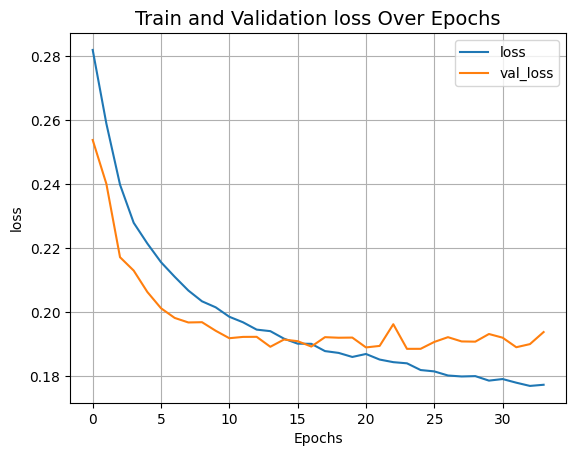

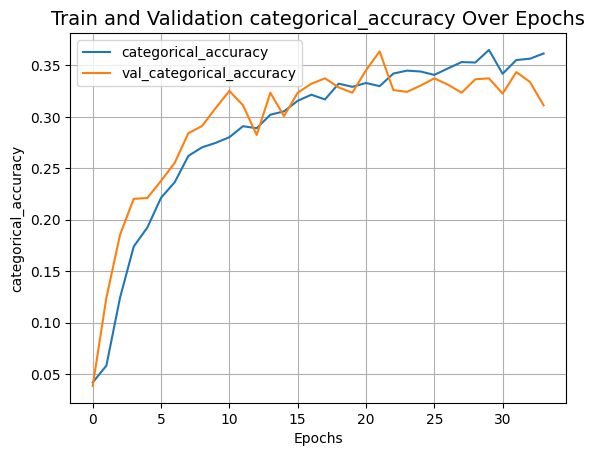

45/45 [==============================] - 7s 113ms/step


0.27599867943215584

In [190]:
model_2 = Sequential()
model_2.add(embedding_layer)
# Dropouts can help correct overfitting by dropping out a fraction of inputs - it can reduce specificity of weights
model_2.add(Dropout(0.5))
model_2.add(LSTM(128, return_sequences=True))
model_2.add(Dropout(0.5))
model_2.add(LSTM(64))
model_2.add(Dropout(0.5))
# model_2.add(Dense(labels_num, activation='softmax'))
model_2.add(
    Dense(units=labels_num, activation="sigmoid")
)  # 'units' - число юнитов в слое нейронки, соответствует числу аутпутов


print(model_2.summary())


rmsprop = optimizers.RMSprop(learning_rate = 0.01, decay = 0.0001)
model_2.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics=['categorical_accuracy'])


history_2 = model_2.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks= [es, csv_logger_2, check_point_2]
)


def plot_result(item):
    plt.plot(history_2.history[item], label=item)
    plt.plot(history_2.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")


out_2 = model_2.predict(x_test)
out_2 = np.array(out_2)

y_pred_2 = np.zeros(out.shape)

# for i in range(len(out[:, 0])):
#     a = out[i, :]
#     index = np.argpartition(a, -5)[-5:]
#     for j in range(len(index)):
#         y_pred[i, index[j]] = 1

y_pred_2[out_2 > 0.5] = 1

f1_score(y_test, y_pred_2, average="micro")

In [199]:
t = 0.2  # threshold value

y_pred_new_2 = np.zeros(out_2.shape)
y_pred_new_2[out_2 > t] = 1

# evaluate performance
f1_score(y_test, y_pred_new_2, average="micro")

0.4154866463523929

In [200]:
# Inference
np.random.seed(2022)

def inference(q, k):
    q_vec = tk.texts_to_sequences(q)
    q_vec = pad_sequences(q_vec, maxlen=max_len, padding='pre')[k]
    q_pred_prob = model_2.predict(q_vec.reshape(1, max_len))
    q_pred = np.zeros(q_pred_prob.shape)
    q_pred[q_pred_prob > t] = 1

    return mlb.inverse_transform(q_pred)


for i in range(5):
    k = np.random.choice(indices_test)
    print(
        "Movie: ",
        df["name"][k],
        "\nPredicted genre: ",
        inference(x, k),
    ), print("Actual genre: ", df["genres"][k], "\n")

1/1 [==============================] - 0s 82ms/step
Movie:  Stalag 17 
Predicted genre:  [('history', 'war', 'western')]
Actual genre:  ['war'] 

1/1 [==============================] - 0s 84ms/step
Movie:  SuperBob 
Predicted genre:  [()]
Actual genre:  ['superhero'] 

1/1 [==============================] - 0s 89ms/step
Movie:  Kabhi Khushi Kabhie Gham... 
Predicted genre:  [('romance',)]
Actual genre:  ['musical'] 

1/1 [==============================] - 0s 80ms/step
Movie:  Django/Zorro 
Predicted genre:  [('action', 'western')]
Actual genre:  ['western'] 

1/1 [==============================] - 0s 88ms/step
Movie:  Lucy 
Predicted genre:  [('adventure', 'fantasy', 'horror', 'mystery', 'sci-fi', 'thriller')]
Actual genre:  ['sci-fi', 'superhero'] 



In [201]:
accuracy_lstm = accuracy_score(y_test, y_pred_new_2)
precision = precision_score(y_test, y_pred_new_2, average="micro")
recall = recall_score(y_test, y_pred_new_2, average="micro")
f1 = f1_score(y_test, y_pred_new_2, average="micro")
log_loss_lstm = log_loss(y_test, out_2)

# Calculation output
print("Precision = ", precision)
print("Recall  = ", recall)
print('Accuracy = ', accuracy_lstm)
print("F1 score = ", f1)
print("Log-loss = ", log_loss_lstm)

Precision =  0.3657305143578416
Recall  =  0.48091286307053943
Accuracy =  0.16573426573426572
F1 score =  0.4154866463523929
Log-loss =  4.15794961959306


In [202]:
results.loc["LSTM(0.5)"] = [
    t,
    precision,
    recall,
    accuracy_lstm,
    f1,
    log_loss_lstm,
]

In [203]:
results

,Probability_threshold,Precision,Recall,Accuracy,F1 score,Log-loss
Logistic Regression,0.122,0.410880,0.502627,0.151049,0.452147,4.041058
Support Vector Machine,0.122,0.937500,0.065674,0.071329,0.122750,_
Decision Tree,0.750,0.294627,0.297723,0.102098,0.296167,30.112624
Random Forest,0.230,0.443107,0.354641,0.184615,0.393969,6.035745
LSTM(0.3),0.270,0.397567,0.442760,0.188112,0.392499,4.465527
LSTM(0.5),0.200,0.365731,0.480913,0.165734,0.415487,4.15795
